<a href="https://colab.research.google.com/github/txin-y/23springNeuralNetworkProject/blob/main/IMDBtextclassification_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
!pip install 'portalocker>=2.0.0'
!pip install portalocker


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import torch
from torchtext.datasets import IMDB
import portalocker
train_iter = iter(IMDB(split='train'))

In [15]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


tokenizer = get_tokenizer('basic_english')
train_iter = IMDB(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [16]:
vocab(['here', 'is', 'an', 'example'])

[131, 9, 40, 464]

In [17]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [18]:
text_pipeline('here is the an example')

[131, 9, 1, 40, 464]

In [19]:
label_pipeline('10')


9

In [20]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_iter = IMDB(split='train')
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [21]:
from torch import nn

# Change the Model from simple networks to LSTM

class LSTMModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(LSTMModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        # self.fc = nn.Linear(embed_dim, num_class)
        self.lstm = nn.LSTM(embed_dim, 128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        # return self.fc(embedded)
        lstm_out, _ = self.lstm(embedded.unsqueeze(1))
        return self.fc(lstm_out[:, -1, :])

In [22]:
train_iter = IMDB(split='train')
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = LSTMModel(vocab_size, emsize, num_class).to(device)

In [11]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        # print(label.shape)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [13]:
# from torch.utils.data.dataset import random_split
# from torchtext.data.functional import to_map_style_dataset
# # Hyperparameters
# EPOCHS = 10 # epoch
# LR = 5  # learning rate
# BATCH_SIZE = 64 # batch size for training

# criterion = torch.nn.CrossEntropyLoss()
# # criterion = torch.nn.BCEWithLogitsLoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
# total_accu = None
# train_iter, test_iter = IMDB()
# train_dataset = to_map_style_dataset(train_iter)
# test_dataset = to_map_style_dataset(test_iter)
# num_train = int(len(train_dataset) * 0.95)
# split_train_, split_valid_ = \
#     random_split(train_dataset, [num_train, len(train_dataset) - num_train])

# train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
#                               shuffle=True, collate_fn=collate_batch)
# valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
#                               shuffle=True, collate_fn=collate_batch)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
#                              shuffle=True, collate_fn=collate_batch)

# for epoch in range(1, EPOCHS + 1):
#     epoch_start_time = time.time()
#     train(train_dataloader)
#     accu_val = evaluate(valid_dataloader)
#     if total_accu is not None and total_accu > accu_val:
#       scheduler.step()
#     else:
#        total_accu = accu_val
#     print('-' * 59)
#     print('| end of epoch {:3d} | time: {:5.2f}s | '
#           'valid accuracy {:8.3f} '.format(epoch,
#                                            time.time() - epoch_start_time,
#                                            accu_val))
#     print('-' * 59)

In [14]:
# print('Checking the results of test dataset.')
# accu_test = evaluate(test_dataloader)
# print('test accuracy {:8.3f}'.format(accu_test))

In [30]:
# Plot the loss and Reduce the BATCH_SIZE from 64 to 16

import time

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()
    train_loss = []
    train_accuracy = []
    losses = []
    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        losses.append(loss.item())
        train_loss.append(loss.item())
        train_accuracy.append(total_acc/total_count)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f} | loss {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count, sum(losses)/len(losses)))
            total_acc, total_count = 0, 0
            losses = []
            start_time = time.time()  
    train_losses.append(sum(train_loss)/len(dataloader))
    train_accuracies.append(sum(train_accuracy)/len(dataloader))
    return train_losses, train_accuracies

def evaluate(dataloader):
    model.eval()
    test_loss = []
    test_accuracy = []
    losses = []
    total_acc, total_count = 0, 0
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            losses.append(loss.item())
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
            test_loss.append(loss.item())
            test_accuracy.append(total_acc/total_count)
        test_losses.append(sum(test_loss)/len(dataloader))
        test_accuracies.append(sum(test_accuracy)/len(dataloader))
    return test_losses, test_accuracies

In [31]:

from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 5 # epoch
LR = 5  # learning rate

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

train_iter = IMDB(split='train')
test_iter = IMDB(split='test')
train_dataset = list(train_iter)
test_dataset = list(test_iter)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    train_losses, train_accuracies = train(train_dataloader)
    test_losses, test_accuracies = evaluate(test_dataloader)
    # test_loss = evaluate(test_dataloader)
    # test_losses.append(test_losses)
    #  = evaluate(train_dataloader)
    # test_accuracy = evaluate(test_dataloader)
    # # train_accuracies.append(train_accuracy)
    # test_accuracies.append(test_accuracy)


| epoch   1 |   500/ 1563 batches | accuracy    0.898 | loss    0.263
| epoch   1 |  1000/ 1563 batches | accuracy    0.896 | loss    0.263
| epoch   1 |  1500/ 1563 batches | accuracy    0.901 | loss    0.261
| epoch   2 |   500/ 1563 batches | accuracy    0.899 | loss    0.265
| epoch   2 |  1000/ 1563 batches | accuracy    0.900 | loss    0.261
| epoch   2 |  1500/ 1563 batches | accuracy    0.896 | loss    0.269
| epoch   3 |   500/ 1563 batches | accuracy    0.907 | loss    0.244
| epoch   3 |  1000/ 1563 batches | accuracy    0.903 | loss    0.260
| epoch   3 |  1500/ 1563 batches | accuracy    0.905 | loss    0.254
| epoch   4 |   500/ 1563 batches | accuracy    0.906 | loss    0.245
| epoch   4 |  1000/ 1563 batches | accuracy    0.906 | loss    0.256
| epoch   4 |  1500/ 1563 batches | accuracy    0.905 | loss    0.250
| epoch   5 |   500/ 1563 batches | accuracy    0.910 | loss    0.234
| epoch   5 |  1000/ 1563 batches | accuracy    0.912 | loss    0.234
| epoch   5 |  1500/

Text(0.5, 0, 'Epochs')

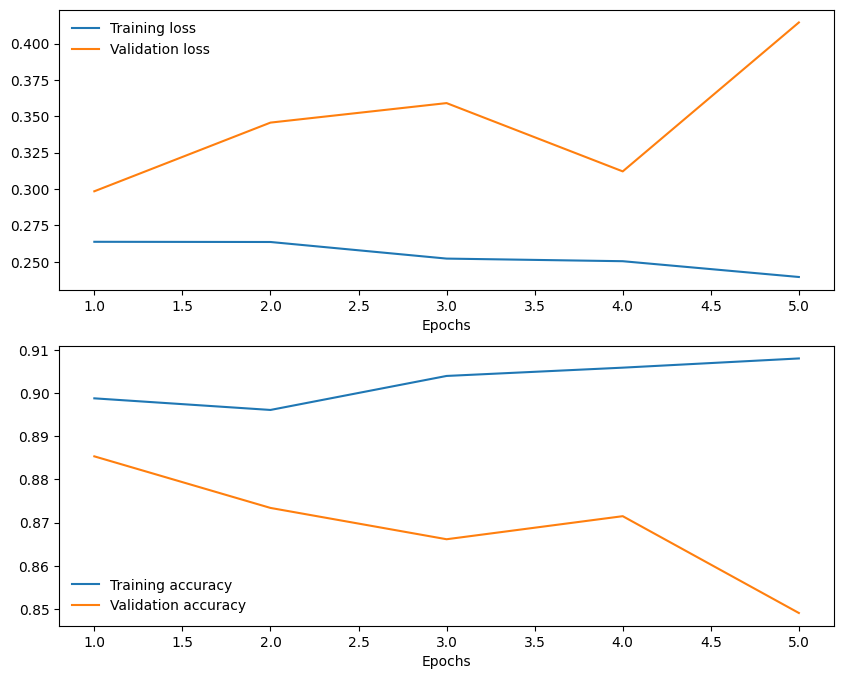

In [36]:
# Create a figure with two subplots
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot training and validation losses
x_axis = range(1, EPOCHS+1)
ax1.plot(x_axis, train_losses, label='Training loss')
ax1.plot(x_axis, test_losses, label='Validation loss')
ax1.legend(frameon=False)
ax1.set_xlabel('Epochs')

# Plot training and validation accuracies
ax2.plot(x_axis, train_accuracies, label='Training accuracy')
ax2.plot(x_axis, test_accuracies, label='Validation accuracy')
ax2.legend(frameon=False)
ax2.set_xlabel('Epochs')


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.metrics import roc_curve, auc

# Initialize empty lists to store training and testing metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
false_positive_rates = []
false_negative_rates = []

| epoch   1 |   500/ 1563 batches | accuracy    0.932 | loss    0.198
| epoch   1 |  1000/ 1563 batches | accuracy    0.927 | loss    0.204
| epoch   1 |  1500/ 1563 batches | accuracy    0.922 | loss    0.217
| epoch   2 |   500/ 1563 batches | accuracy    0.927 | loss    0.211
| epoch   2 |  1000/ 1563 batches | accuracy    0.934 | loss    0.189
| epoch   2 |  1500/ 1563 batches | accuracy    0.928 | loss    0.211
| epoch   3 |   500/ 1563 batches | accuracy    0.933 | loss    0.196
| epoch   3 |  1000/ 1563 batches | accuracy    0.930 | loss    0.201
| epoch   3 |  1500/ 1563 batches | accuracy    0.925 | loss    0.212
| epoch   4 |   500/ 1563 batches | accuracy    0.937 | loss    0.182
| epoch   4 |  1000/ 1563 batches | accuracy    0.933 | loss    0.192
| epoch   4 |  1500/ 1563 batches | accuracy    0.929 | loss    0.202
| epoch   5 |   500/ 1563 batches | accuracy    0.933 | loss    0.190
| epoch   5 |  1000/ 1563 batches | accuracy    0.936 | loss    0.189
| epoch   5 |  1500/

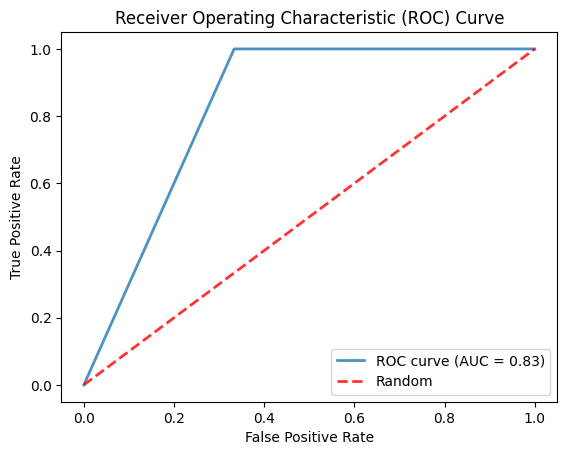

In [28]:
# Define the training function
def train(dataloader):
    # Set the model to training mode
    model.train()
    total_acc, total_count = 0, 0
    # Set the interval for logging
    log_interval = 500
    start_time = time.time()
    # Initialize empty lists to store training metrics
    train_loss = []
    train_accuracy = []
    losses = []
    # Loop through the data in the dataloader
    for idx, (label, text, offsets) in enumerate(dataloader):
        # Zero out the gradients
        optimizer.zero_grad()
        # Make a prediction with the model
        predicted_label = model(text, offsets)
        # Calculate the loss
        loss = criterion(predicted_label, label)
        # Backpropagate the loss
        loss.backward()
        # Clip the gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        # Update the weights
        optimizer.step()
        # Update the accuracy and count variables
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        # Append the loss to the losses list
        losses.append(loss.item())
        # Append the loss and accuracy to their respective lists
        train_loss.append(loss.item())
        train_accuracy.append(total_acc/total_count)
        # Log the progress at the specified interval
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f} | loss {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count, sum(losses)/len(losses)))
            total_acc, total_count = 0, 0
            losses = []
            start_time = time.time()  
    # Append the average loss and accuracy to their respective lists
    train_losses.append(sum(train_loss)/len(dataloader))
    train_accuracies.append(sum(train_accuracy)/len(dataloader))
    return train_losses, train_accuracies

In [ ]:
# Define the evaluation function
def evaluate(dataloader):
    # Set the model to evaluation mode
    model.eval()
    # Initialize empty lists to store testing metrics
    test_loss = []
    test_accuracy = []
    losses = []
    total_acc, total_count = 0, 0
    false_positives, false_negatives = 0, 0
    labels = []
    predicted_labels = [] 
    # Turn off gradient calculation
    with torch.no_grad():
        # Loop through the data in the dataloader
        for idx, (label, text, offsets) in enumerate(dataloader):
            # Append the label to the labels list
            labels.append(label)
            # Make a prediction with the model
            predicted_label = model(text, offsets)
            # Append the predicted label to the predicted_labels list
            predicted_labels.append(predicted_label.argmax(1))
            # Calculate the loss
            loss = criterion(predicted_label, label)
            # Append the loss to the losses list
            losses.append(loss.item())
            # Update the accuracy and count variables
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
            # Append the loss and accuracy to their respective lists
            test_loss.append(loss.item())
            test_accuracy.append(total_acc/total_count)
            # Calculate the false positives and false negatives
            false_positives += ((predicted_label.argmax(1) == 1) & (label == 0)).sum().item()
            false_negatives += ((predicted_label.argmax(1) == 0) & (label == 1)).sum().item()
        # Append the average loss and accuracy to their respective lists
        test_losses.append(sum(test_loss)/len(dataloader))
        test_accuracies.append(sum(test_accuracy)/len(dataloader))
        # Calculate the false positive rate and false negative rate
        false_positive_rate = false_positives / (false_positives + total_count - total_acc)
        false_negative_rate = false_negatives / (false_negatives + total_acc)
        # Append the false positive rate and false negative rate to their respective lists
        false_positive_rates.append(false_positive_rate)
        false_negative_rates.append(false_negative_rate)
        # Plot the ROC curve if it is the last epoch
        if epoch == EPOCHS:
          fpr, tpr, _ = roc_curve(label.cpu().numpy(), predicted_label.cpu().numpy()[:, 1])
          fpr, tpr, _ = roc_curve(label.cpu().numpy(), predicted_label.argmax(1).cpu().numpy())
          roc_auc = auc(fpr, tpr)
          plt.plot(fpr, tpr, lw=2, alpha=0.8, label='ROC curve (AUC = %0.2f)' % roc_auc)
          plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8)
          plt.xlabel('False Positive Rate')
          plt.ylabel('True Positive Rate')
          plt.title('Receiver Operating Characteristic (ROC) Curve')
          plt.legend(loc="lower right")
          plt.show()
    return test_losses, test_accuracies, false_positive_rates, false_negative_rates, predicted_labels, labels

In [ ]:
# Set the hyperparameters
EPOCHS = 5 # epoch
LR = 5  # learning rate

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# Load the data and create dataloaders
train_iter = IMDB(split='train')
test_iter = IMDB(split='test')
train_dataset = list(train_iter)
test_dataset = list(test_iter)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    # Train the model and get the training metrics
    train_losses, train_accuracies = train(train_dataloader)
    # Evaluate the model and get the testing metrics
    test_losses, test_accuracies, _, _, _, _ = evaluate(test_dataloader)

| epoch   1 |   500/ 1563 batches | accuracy    0.915 | loss    0.229
| epoch   1 |  1000/ 1563 batches | accuracy    0.913 | loss    0.236
| epoch   1 |  1500/ 1563 batches | accuracy    0.913 | loss    0.234
| epoch   2 |   500/ 1563 batches | accuracy    0.916 | loss    0.229
| epoch   2 |  1000/ 1563 batches | accuracy    0.919 | loss    0.227
| epoch   2 |  1500/ 1563 batches | accuracy    0.921 | loss    0.221
| epoch   3 |   500/ 1563 batches | accuracy    0.920 | loss    0.222
| epoch   3 |  1000/ 1563 batches | accuracy    0.918 | loss    0.220
| epoch   3 |  1500/ 1563 batches | accuracy    0.916 | loss    0.230
| epoch   4 |   500/ 1563 batches | accuracy    0.929 | loss    0.206
| epoch   4 |  1000/ 1563 batches | accuracy    0.918 | loss    0.229
| epoch   4 |  1500/ 1563 batches | accuracy    0.920 | loss    0.217
| epoch   5 |   500/ 1563 batches | accuracy    0.927 | loss    0.212
| epoch   5 |  1000/ 1563 batches | accuracy    0.920 | loss    0.221
| epoch   5 |  1500/

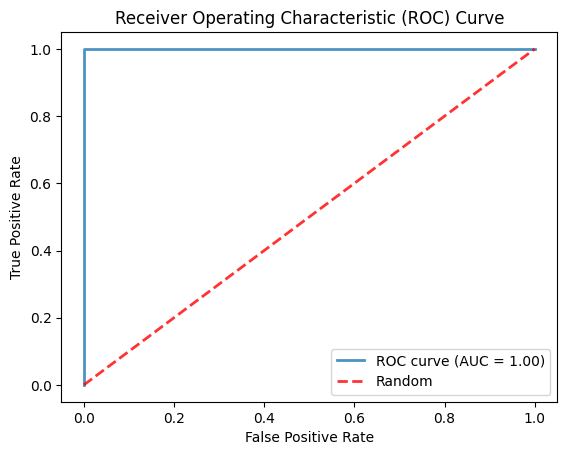

In [27]:
# # Plot the loss and Reduce the BATCH_SIZE from 64 to 16
# import matplotlib.pyplot as plt
# import numpy as np

# import time
# from sklearn.metrics import roc_curve, auc

# train_losses = []
# test_losses = []
# train_accuracies = []
# test_accuracies = []
# false_positive_rates = []
# false_negative_rates = []

# def train(dataloader):
#     model.train()
#     total_acc, total_count = 0, 0
#     log_interval = 500
#     start_time = time.time()
#     train_loss = []
#     train_accuracy = []
#     losses = []
#     for idx, (label, text, offsets) in enumerate(dataloader):
#         optimizer.zero_grad()
#         predicted_label = model(text, offsets)
#         loss = criterion(predicted_label, label)
#         loss.backward()
#         torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
#         optimizer.step()
#         total_acc += (predicted_label.argmax(1) == label).sum().item()
#         total_count += label.size(0)
#         losses.append(loss.item())
#         train_loss.append(loss.item())
#         train_accuracy.append(total_acc/total_count)
#         if idx % log_interval == 0 and idx > 0:
#             elapsed = time.time() - start_time
#             print('| epoch {:3d} | {:5d}/{:5d} batches '
#                   '| accuracy {:8.3f} | loss {:8.3f}'.format(epoch, idx, len(dataloader),
#                                               total_acc/total_count, sum(losses)/len(losses)))
#             total_acc, total_count = 0, 0
#             losses = []
#             start_time = time.time()  
#     train_losses.append(sum(train_loss)/len(dataloader))
#     train_accuracies.append(sum(train_accuracy)/len(dataloader))
#     return train_losses, train_accuracies

# def evaluate(dataloader):
#     model.eval()
#     test_loss = []
#     test_accuracy = []
#     losses = []
#     total_acc, total_count = 0, 0
#     false_positives, false_negatives = 0, 0
#     labels = []
#     predicted_labels = [] 
#     with torch.no_grad():
#         for idx, (label, text, offsets) in enumerate(dataloader):
#             labels.append(label)
#             predicted_label = model(text, offsets)
#             predicted_labels.append(predicted_label.argmax(1))
#             loss = criterion(predicted_label, label)
#             losses.append(loss.item())
#             total_acc += (predicted_label.argmax(1) == label).sum().item()
#             total_count += label.size(0)
#             test_loss.append(loss.item())
#             test_accuracy.append(total_acc/total_count)
#             false_positives += ((predicted_label.argmax(1) == 1) & (label == 0)).sum().item()
#             false_negatives += ((predicted_label.argmax(1) == 0) & (label == 1)).sum().item()
#         test_losses.append(sum(test_loss)/len(dataloader))
#         test_accuracies.append(sum(test_accuracy)/len(dataloader))
#         false_positive_rate = false_positives / (false_positives + total_count - total_acc)
#         false_negative_rate = false_negatives / (false_negatives + total_acc)
#         false_positive_rates.append(false_positive_rate)
#         false_negative_rates.append(false_negative_rate)
#         # print(idx)
#         # print(len(dataloader))
#         if epoch == EPOCHS:
#           fpr, tpr, _ = roc_curve(label.cpu().numpy(), predicted_label.cpu().numpy()[:, 1])
#           fpr, tpr, _ = roc_curve(label.cpu().numpy(), predicted_label.argmax(1).cpu().numpy())
#           roc_auc = auc(fpr, tpr)
#           plt.plot(fpr, tpr, lw=2, alpha=0.8, label='ROC curve (AUC = %0.2f)' % roc_auc)
#           plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8)
#           plt.xlabel('False Positive Rate')
#           plt.ylabel('True Positive Rate')
#           plt.title('Receiver Operating Characteristic (ROC) Curve')
#           plt.legend(loc="lower right")
#           plt.show()
#     return test_losses, test_accuracies, false_positive_rates, false_negative_rates, predicted_labels, labels


# from torch.utils.data.dataset import random_split
# from torchtext.data.functional import to_map_style_dataset
# # Hyperparameters
# EPOCHS = 5 # epoch
# LR = 5  # learning rate

# criterion = torch.nn.CrossEntropyLoss().to(device)
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)

# train_iter = IMDB(split='train')
# test_iter = IMDB(split='test')
# train_dataset = list(train_iter)
# test_dataset = list(test_iter)

# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_batch)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=collate_batch)

# for epoch in range(1, EPOCHS + 1):
#     train_losses, train_accuracies = train(train_dataloader)
#     test_losses, test_accuracies, _, _, _, _ = evaluate(test_dataloader)
